# Creating a zarr store for the RACMO 2km snowmelt (2010-2022)
Ben Davison put many netcdfs containing 2km downscaled output from RACMO. They contain the snowmelt product as 2km from 2010-2022. 

This notebook steps through the process of getting all those data into one zarr store locally and in the bucket:
1. find the files
2. load each netcdf while unzipping
3. save each to a local zarr
4. load all the zarrs lazily and concatenate
5. write the whole dataset to disk and/or the bucket using rechunker

In [ ]:
import xarray as xr
import os
import hvplot as hv
import fsspec
import pickle
import gzip
import tqdm
from rechunker import rechunk
from dask.diagnostics import ProgressBar
import json
import zarr
import numpy as np


## find the netcdf files in the bucket
(dont bother searching if we have previously saved a list of them in a pickle file)

In [2]:
# if files.pkl exists, load it
if os.path.exists("files.pkl"):
    with open("files.pkl", "rb") as f:
        files = pickle.load(f)
else:

    fs = fsspec.filesystem("gcs")
    files = fs.glob("ldeo-glaciology/RACMO_2km/snowmelt/*.nc.gz")
    files = [f"gcs://{file}" for file in files]
    len(files)
    # save the list files to disk using pickle
    with open("files.pkl", "wb") as f:
        pickle.dump(files, f)

## Define some functions for opening netcdfs that are compressed with gz

In [3]:
def load_gcs_gz_dataset(gcs_url):
    """
    Load a gzipped NetCDF dataset from Google Cloud Storage (GCS) using xarray.
    
    Parameters:
    gcs_url (str): The GCS URL of the gzipped NetCDF file.
    
    Returns:
    xarray.Dataarray: The loaded dataset.
    """
    # Open the GCS file as binary
    with fsspec.open(gcs_url, mode='rb') as gcs_file:
        # Decompress with gzip
        with gzip.GzipFile(fileobj=gcs_file, mode='rb') as gz_file:
            # Load with xarray using netCDF4 engine
            return xr.open_dataset(gz_file, chunks={"x": -1, "y": -1, "time": 1})

def extract_snowmelt_DA(gcs_url):
    ds = load_gcs_gz_dataset(gcs_url)
    ds.snowmeltcorr.attrs = ds.snowmeltcorr.attrs | ds.attrs
    return ds


## load each netcdf and save a zarr locally

In [5]:
#!rm -rf temp_zarrs/*
for i, file in enumerate(tqdm.tqdm(files)):
    #print(f"Processing file {i+1}/{len(files)}: {file}")
    ds = extract_snowmelt_DA(file)
    
    ds.to_zarr(f"temp_zarrs/snowmelt{i}.zarr") # save each to a zarr on my laptop
    

100%|██████████| 52/52 [15:14<00:00, 17.58s/it]


## open each zarr lazily and put them in a list

In [16]:
ds_list = [xr.open_dataset(f"temp_zarrs/snowmelt{i}.zarr", chunks={"x": -1, "y": -1, "time": 1}, decode_cf=True) for i in range(len(files))]

## concatenate the datasets 

In [26]:
all = xr.concat(ds_list, dim="time").sortby("time")

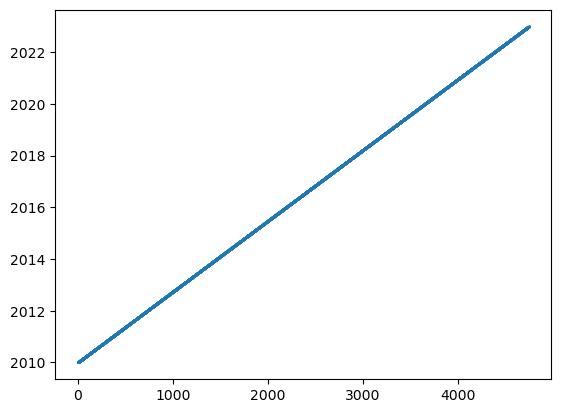

In [48]:
import matplotlib.pyplot as plt
plt.plot(all.time.values, linestyle='None', marker='o', markersize=1)

## get a token for writing to the bucket

In [28]:
with open('/Users/jkingslake/Documents/science/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)

## start a local dask cluster

In [46]:
from dask.distributed import Client, LocalCluster
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53053,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:53067,Total threads: 2
Dashboard: http://127.0.0.1:53072/status,Memory: 6.00 GiB
Nanny: tcp://127.0.0.1:53056,


## Save to zarr with desired chunking to google cloud

In [40]:
all.snowmeltcorr.encoding

{'chunks': (1, 2303, 2778),
 'preferred_chunks': {'time': 1, 'y': 2303, 'x': 2778},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'missing_value': nan,
 '_FillValue': nan,
 'dtype': dtype('float32')}

In [ ]:
all.snowmeltcorr.encoding['missing_value'] = np.nan

In [54]:
mapper = fsspec.get_mapper('gs://ldeo-glaciology/RACMO_2km/snowmelt_v2.zarr', mode='w', token=token)

array_plan = rechunk(source = all, 
                     target_chunks = {"x": -1, "y": -1, "time": 10}, 
                     max_mem = "500MB", 
                     target_store = mapper,
                     temp_store='rechunking_temp')
with ProgressBar():
    array_plan.execute()
zarr.consolidate_metadata(mapper)

<zarr.hierarchy.Group '/'>

## check we can reload from the bucket

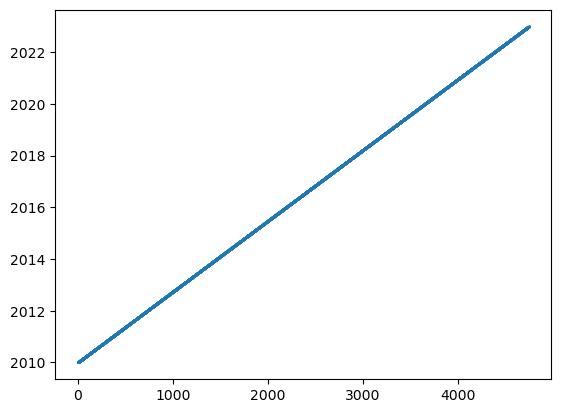

In [55]:
all_reloaded = xr.open_dataset(mapper, engine = 'zarr', chunks = {})
plt.plot(all_reloaded.time.values, linestyle='None', marker='o', markersize=1)

## save a local copy too

In [47]:
mapper = fsspec.get_mapper('full_2km_zarr/snowmelt.zarr', mode='w', token=token)

array_plan = rechunk(source = all, 
                     target_chunks = {"x": -1, "y": -1, "time": 10}, 
                     max_mem = "500MB", 
                     target_store = mapper,
                     temp_store='rechunking_temp')
array_plan.execute()
zarr.consolidate_metadata(mapper)

<zarr.hierarchy.Group '/'>

In [51]:
all_reloaded_local = xr.open_dataset('full_2km_zarr/snowmelt.zarr', engine = 'zarr', chunks = {})
all_reloaded_local

<xarray.Dataset> Size: 122GB
Dimensions:       (time: 4748, y: 2303, x: 2778)
Coordinates:
  * time          (time) datetime64[ns] 38kB 2010-01-01 ... 2022-12-31
  * x             (x) float32 11kB -2.731e+06 -2.729e+06 ... 2.821e+06 2.823e+06
  * y             (y) float32 9kB -2.232e+06 -2.23e+06 ... 2.37e+06 2.372e+06
Data variables:
    snowmeltcorr  (time, y, x) float32 122GB dask.array<chunksize=(10, 2303, 2778), meta=np.ndarray>
Attributes:
    grid:         Map Projection: Antarctic Polar Stereographic EPSG3031 - Ma...
    history:      libUN (2013.05.22) - Sat Dec 11 10:31:43 2021
    institution:  IMAU (Brice Noel)
    netcdf:       4.7.4 of Apr 18 2020 10:56:44 $
    title:        Daily mean snowmelt field at 2km (RACMO2.3p2) ERA

## plotting

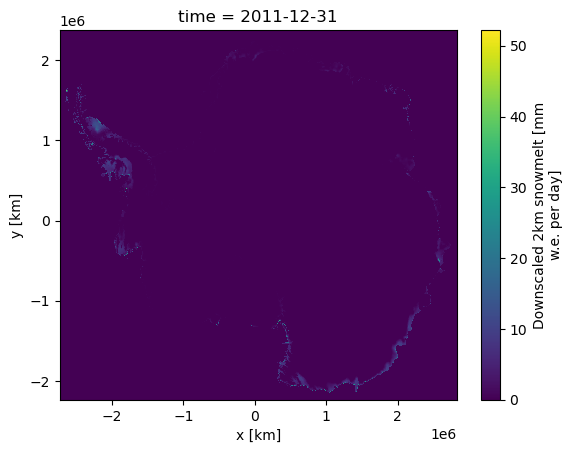

In [58]:
all_reloaded_local.sel(time = "31-12-2011").snowmeltcorr.plot()